In [24]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import mplhep as hep
import pickle
import pandas as pd
import glob

In [25]:
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector
ak.behavior.update(candidate.behavior)

def getLZDF(f,treename ="MuonSystem",nEvents=-1):
    events_raw = uproot.open(f)[treename]
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    events = events[start:stop]
    if treename=="MuonSystem":
        return pack(events)
    else:
        return events
        

def pack(events):
    events.info=ak.zip({
        "runNum": events.runNum,
        "lumiNum": events.lumiNum,
        "evtNum": events.eventNum,
        }
    )
    events.cls=ak.zip({
        'eta':events.ca4CSCclusterEta,
        'phi':events.ca4CSCclusterPhi,
        'x':events.ca4CSCclusterX,        
        'y':events.ca4CSCclusterY,
        'z':events.ca4CSCclusterZ,                
        'size':events.ca4CSCclusterSize,
        'time':events.ca4CSCclusterTime,
        'timeSpread':events.ca4CSCclusterTimeSpread,            
        "nME11_12": events.ca4CSCclusterME11_12,
        'time':events.ca4CSCclusterTime,            
        "nStation10": events.ca4CSCclusterNstation10,
        "avgStation10": events.ca4CSCclusterAvgStation10,            
        }    
    )
    events.cls_dt=ak.zip({
        'eta': events.ca4DTclusterEta,
        'phi': events.ca4DTclusterPhi,
        'x':   events.ca4DTclusterX,        
        'y':   events.ca4DTclusterY,
        'z':   events.ca4DTclusterZ,                
        'size':events.ca4DTclusterSize,
        'time':events.ca4DTclusterTime,
        "nMB1": events.ca4DTclusterMB1,
        "nMB2": events.ca4DTclusterMB2,            
        "nStation10": events.ca4DTclusterNstation10,
        "avgStation10": events.ca4DTclusterAvgStation10,            
        }    
    )
    return events

def plotCls(d=[{"cls":"cls","label":"data"}],version="new",density=False):
    
    fig, axs = plt.subplots(6,2,figsize=(16,36))
#     hep.set_style(hep.style.CMS)
    plt.style.use(hep.style.CMS) 
    axs = axs.flatten()
    density = density
    h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nClusters", "nClusters", 10, 0, 10))
    h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("eta", "eta", 40, -5, 5))    
    h3= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("phi", "phi", 40, -np.pi, np.pi))        
    h4= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("size", "size", 100, 0, 1000))        
    h5= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("time", 'ClusterTime[ns]',80, -80, 80))            
    if version=="DT":
        h6 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nMB1", 'nMB1',40, 0, 40))
        h12= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nMB2", "nMB2", 40, 0, 40))        
    else:
        h6 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nME11_12", 'nME11_12',40, 0, 40))        
        h12= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("timeSpread", "timeSpread[ns]", 80, 0, 100))
        
    h7 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("x", "x", 100, -1000, 1000))        
    h8 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("y", "y", 100, -1000, 1000))        
    h9 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("z", "z", 120, -1200, 1200))            
    h10= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Nstation10", "Nstation10", 8, 0, 8))    
    h11= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("AvgStation10", "AvgStation10", 40, 0, 8))    
    
    hall = [h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12]
    for sample in d:
        cls = sample['cls']
        label = sample['label']
        h1.fill(sample=label,nClusters=ak.num(cls))
        h2.fill(sample=label,eta = ak.flatten(cls.eta))
        h3.fill(sample=label,phi = ak.flatten(cls.phi)) 
        h4.fill(sample=label,size = ak.flatten(cls.size))
        h5.fill(sample=label,time = ak.flatten(cls.time)) 
        if version=="DT":
            h6.fill (sample=label,nMB1 = ak.flatten(cls.nMB1))        
            h12.fill(sample=label,nMB2 = ak.flatten(cls.nMB2))                
        elif version=="new":
            h6.fill (sample=label,nME11_12 = ak.flatten(cls.nME11_12))
            h12.fill(sample=label,timeSpread = ak.flatten(cls.timeSpread))                
        else:
            h6.fill(sample=label,nME11_12 = ak.flatten(cls.nME11+cls.nME12))        

        h7.fill( sample=label,x = ak.flatten(cls.x))    
        h8.fill( sample=label,y = ak.flatten(cls.y))    
        h9.fill( sample=label,z = ak.flatten(cls.z))        
        h10.fill(sample=label,Nstation10 = ak.flatten(cls.nStation10))            
        h11.fill(sample=label,AvgStation10 = ak.flatten(cls.avgStation10))                
    
    
    hist.plot1d(h1,density=density,ax=axs[0])
    hist.plot1d(h2,density=density,ax=axs[1])
    hist.plot1d(h3,density=density,ax=axs[2])
    hist.plot1d(h4,density=density,ax=axs[3])
    hist.plot1d(h5,density=density,ax=axs[4])
    hist.plot1d(h6,density=density,ax=axs[5])    
    hist.plot1d(h7,density=density,ax=axs[6])    
    hist.plot1d(h8,density=density,ax=axs[7])    
    hist.plot1d(h9,density=density,ax=axs[8])    
    hist.plot1d(h10,density=density,ax=axs[9])    
    hist.plot1d(h11,density=density,ax=axs[10])    
    hist.plot1d(h12,density=density,ax=axs[11])        
    
    if density:
        axs[5].set_yscale("log")
        axs[5].set_ylim(1e-4,None)
    axs[3].set_yscale("log")
    axs[3].set_ylim(1e-4,None)
        
    for ax in axs:
        hep.cms.label(ax=ax,data=True,label="Preliminary")        
        if density: ax.set_ylabel("Density")
        ax.legend(title="run355404")
    plt.tight_layout()
    plt.show()
    

In [32]:
run2_wire = getLZDF('../MaxDigis_tree_Data.root',"wire")
run2_comp = getLZDF('../MaxDigis_tree_Data.root',"comparator")

In [43]:
# f = "../hmt_ntuple_355933_mu.root"
f = "../hmt_ntuple_355404_zb_v2.root"
# f = "../hmt_ntuple_3557329_mu.root"

events = getLZDF(f)
hmt = getLZDF(f,'simpleCSCshowerFilter/hmt')
hmt = hmt[hmt.passL1==1]
cls = ak.zip(
    {k.replace("ca4CSCcluster",""):getattr(events,k) for k in events.fields if k.startswith("ca4CSCcluster")}
    ,with_name="PtEtaPhiMLorentzVector", 
    behavior=vector.behavior
    )

muons = ak.zip(
    {k.replace("muon",""):getattr(hmt,k) for k in hmt.fields if k.startswith("muon")}
    ,with_name="PtEtaPhiMLorentzVector", 
    behavior=vector.behavior
    )
lctHMT = ak.zip({k.replace("lctHMT_",""):getattr(hmt,k) for k in hmt.fields if k.startswith("lctHMT_")})
elctHMT = ak.zip({k.replace("elctHMT_",""):getattr(hmt,k) for k in hmt.fields if k.startswith("elctHMT_")})

hmt.uniqueStation = ak.max(hmt.cscRechitsChamber,axis=1)==ak.min(hmt.cscRechitsChamber,axis=1)
hmt.passL1_emul = ak.any(hmt.elctHMT_bits>1,axis=1)
cls.R = (cls.X**2+ cls.Y**2)**0.5
mu_veto = ~(ak.all( (hmt.muonPt>10)&(hmt.muonIsGlobal)&(hmt.muonIsMedium) ,axis=1) )

In [3]:
f = "../plots_run357696_to_run357756.root"

# Nevents = 100000
Nevents = -1
hmt = getLZDF(f,'simpleCSCshowerFilter/hmt',Nevents)

# f = "../plots_run357688.root"
f = "../plots_run357696_to_run357756_l1pass.root"

# hmt = getLZDF(f,'simpleCSCshowerFilter/hmt')

In [4]:
cls = ak.zip(
    {k.replace("ca4CSCcluster",""):getattr(hmt,k) for k in hmt.fields if k.startswith("ca4CSCcluster")}
    ,with_name="PtEtaPhiMLorentzVector", 
    behavior=vector.behavior
    )

muons = ak.zip(
    {k.replace("muon",""):getattr(hmt,k) for k in hmt.fields if k.startswith("muon")}
    ,with_name="PtEtaPhiMLorentzVector", 
    behavior=vector.behavior
    )

lctHMT = ak.zip({k.replace("lctHMT_",""):getattr(hmt,k) for k in hmt.fields if k.startswith("lctHMT_")})
elctHMT = ak.zip({k.replace("elctHMT_",""):getattr(hmt,k) for k in hmt.fields if k.startswith("elctHMT_")})

hmt.uniqueStation = ak.max(hmt.cscRechitsChamber,axis=1)==ak.min(hmt.cscRechitsChamber,axis=1)
hmt.passL1_emul = ak.any(hmt.elctHMT_bits>1,axis=1)
cls.R = (cls.X**2+ cls.Y**2)**0.5
mu_veto = ~(ak.all( (hmt.muonPt>10)&(hmt.muonIsGlobal)&(hmt.muonIsMedium) ,axis=1) )

In [42]:
elctHMT.fields

['chamber', 'sr', 'bits', 'BX', 'ComparatorNHits', 'WireNHits']

In [44]:
hmt.passL1

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='18985 * int32'>

In [47]:
# match = (hmt.nelctHMT==hmt.nlctHMT) &(hmt.nlctHMT==1) & (hmt.nelctHMT==1)
match = (hmt.nelctHMT==hmt.nlctHMT) 
m1 = elctHMT[match]
# m = m1[m1.bits==lctHMT[match].bits]
m = m1[ak.max(m1.bits,axis=1)==ak.max(lctHMT[match].bits,axis=1)]

labels  = ["ME11","ME12","ME13",'ME21','ME22','ME31','ME32',"ME41","ME42"]
regions =[(8,9),(7,10),(6,11),(5,12),(4,13),(3,14),(2,15),(1,16),(0,17)]
nom_lines     = [140,41,12,56,18,55,16,62,27]
tight_lines   = [140,45,16,58,22,57,20,64,31]
newNorm_lines = [140,140,16,58,28,57,26,64,31]

In [62]:

cuts = [((m.sr==region[0])|(m.sr==region[1]))&(m.WireNHits>=tight_lines[i]) for i,region in enumerate(regions)]
# cuts = [((m.sr==region[0])|(m.sr==region[1]))&(m.WireNHits>=newNorm_lines[i]) for i,region in enumerate(regions)]
# cuts = [((m.sr==region[0])|(m.sr==region[1]))&(m.WireNHits>=nom_lines[i]) for i,region in enumerate(regions)]
# cuts = [((m.sr==region[0])|(m.sr==region[1])) for i,region in enumerate(regions)]
mask = (cuts[0])|(cuts[1])|(cuts[2])|(cuts[3])|(cuts[4])|(cuts[5])|(cuts[6])|(cuts[7])|(cuts[8])

In [52]:
nominal_tot = ak.sum(mask)

In [59]:
ak.sum(mask)

2291

In [53]:
nominal_tot

2291

In [63]:
# tot = len(ak.flatten(m.WireNHits))
for i,cut in enumerate(cuts):
    print(labels[i],ak.sum(cut),"%.2f "%(ak.sum(cut)*100/nominal_tot))
print("%.3f"%(ak.sum(mask)/nominal_tot))

ME11 0 0.00 
ME12 349 15.23 
ME13 45 1.96 
ME21 12 0.52 
ME22 801 34.96 
ME31 10 0.44 
ME32 408 17.81 
ME41 10 0.44 
ME42 105 4.58 
0.759


In [111]:
m.sr

<Array [[13], [10], [13], ... [2], [15], [10]] type='20529 * var * int32'>

In [96]:
ak.sum(mask)/len(ak.flatten(m.WireNHits))

0.3128390596745027

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


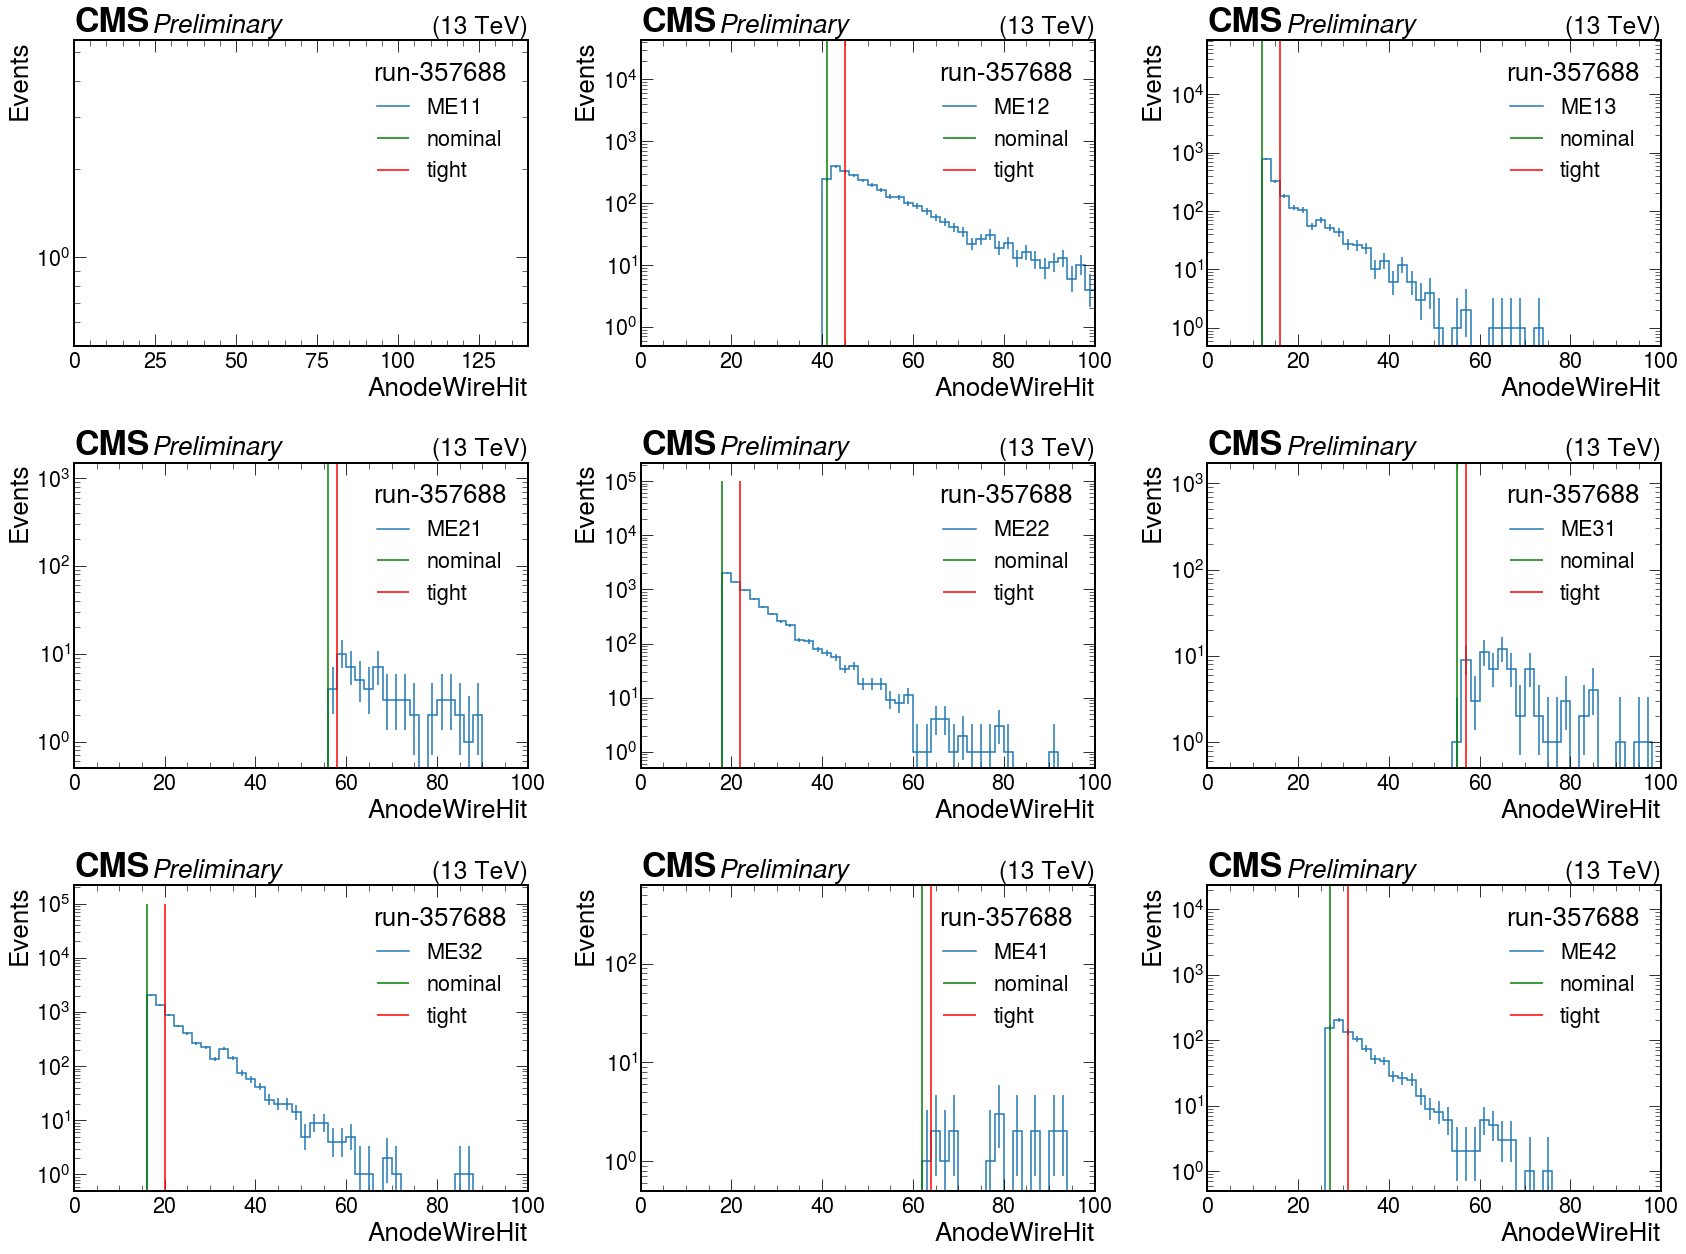

In [150]:
plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(3,3, figsize=(24,18))
axs = axs.flatten()

def plotNhit(ax,hmtNhit):
    h= hist.Hist("Events",hist.Bin("Nhit", "AnodeWireHit", 50, 0, 100))        
    h.fill(Nhit=ak.flatten(hmtNhit))
    hist.plot1d(h,ax=ax)
    ax.set_yscale("log")
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(0.5,ymax*100)    
    return ax

for i,region in enumerate([(8,9),(7,10),(6,11),(5,12),(4,13),(3,14),(2,15),(1,16),(0,17)]):
    match = (hmt.nelctHMT==hmt.nlctHMT) &(hmt.nlctHMT==1) & (hmt.nelctHMT==1)
    m= elctHMT[match]
    bit_match = (m.bits==lctHMT[match].bits)   
    nhits = m[((m.sr==region[0])|(m.sr==region[1])) &(bit_match) ].WireNHits
    plotNhit(axs[i],nhits)

labels = ["ME11","ME12","ME13",'ME21','ME22','ME31','ME32',"ME41","ME42"]
nom_lines = [140,41,12,56,18,55,16,62,27]
tight_lines = [140,45,16,58,22,57,20,64,31]

runNumber = "run-357688"
for i,ax in enumerate(axs):
    ax.vlines(nom_lines[i],0,1e5,color="g")    
    ax.vlines(tight_lines[i],0,1e5,color="r")        
    ax.legend(["%s"%labels[i],"nominal",'tight'],title=runNumber,loc="upper right")
    hep.cms.label(ax=ax,data=True,label="Preliminary")
plt.tight_layout()

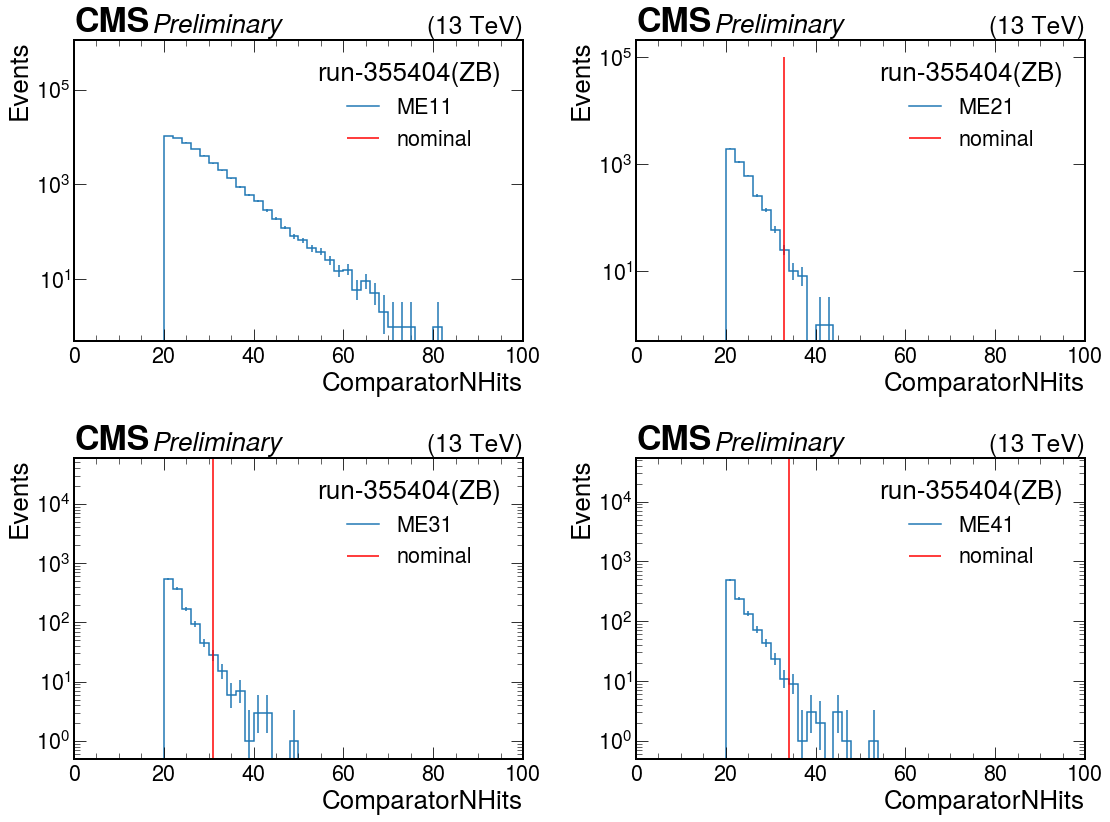

In [201]:
plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs = axs.flatten()

def plotNhit(ax,hmtNhit):
    h= hist.Hist("Events",hits.Cat("sample","sample"),
                 hist.Bin("Nhit", "ComparatorNHits", 50, 0, 100))        
    h.fill(sample="run3",Nhit=ak.flatten(hmtNhit))
    hist.plot1d(h,ax=ax)
    ax.set_yscale("log")
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(0.5,ymax*100)     
    return ax

for i,region in enumerate([(8,9),(5,12),(3,14),(1,16)]):
    match = (hmt.nelctHMT==hmt.nlctHMT) &(hmt.nlctHMT==1) & (hmt.nelctHMT==1)
    m= elctHMT[match]
    bit_match = ak.all((m.bits==lctHMT[match].bits),axis=1)   
    
    nhits = m[(m.sr==region[0])|(m.sr==region[1]) &bit_match ].ComparatorNHits
    if ak.sum(sel)>0:
        plotNhit(axs[i],nhits)

labels = ["ME11",'ME21','ME31',"ME41"]
nom_lines = [100,33,31,34]
# runNumber = "run-357688"
runNumber = "run-355404(ZB)"
for i,ax in enumerate(axs):
    ax.vlines(nom_lines[i],0,1e5,color="r")    
    ax.legend(["%s"%labels[i],"nominal"],title=runNumber)
    hep.cms.label(ax=ax,data=True,label="Preliminary")
plt.tight_layout()

In [7]:
def HLTFilters(cls,thres=[]):
    L1cls = cls
    L1cls = L1cls[(L1cls.Time<12.5)&(L1cls.Time>-5)&(L1cls.ME11_12==0)]
#     L1cls = L1cls[(L1cls.Time<12.5)&(L1cls.Time>-5)]
#     L1cls = L1cls[(L1cls.ME11_12==0)]
    c1 = ak.any((abs(L1cls.Eta)<=1.9)&(L1cls.Nstation10>1) & (L1cls.Size>=thres[0]),axis=1)
    c2 = ak.any((abs(L1cls.Eta)<=1.9)&(L1cls.Nstation10<=1) &(L1cls.Size>=thres[1]),axis=1)
    c3 = ak.any((abs(L1cls.Eta)>1.9)&(L1cls.Nstation10>1) &  (L1cls.Size>=thres[2]),axis=1)
    c4 = ak.any((abs(L1cls.Eta)>1.9)&(L1cls.Nstation10<=1) & (L1cls.Size>=thres[3]),axis=1)
    mask = (c1|c2|c3|c4)
    return mask
HLTLoose  = HLTFilters(cls,[100,200,500,500])
HLTMedium = HLTFilters(cls,[100,300,500,800])
HLTTight  = HLTFilters(cls,[100,500,500,800])

In [335]:
sel= ak.all((cls.Nstation10==1)
            &(cls.TimeSpread<10)
            &(abs(cls.Eta)<2)
#             &(cls.Time<20)&(cls.Time>0)
            ,axis=1) #& (hmt.uniqueStation==1)

denom = ak.max(cls[sel].Size,axis=1)
# numer = denom[hmt.passL1_emul[sel]==1]
numer = denom[hmt[sel].passL1==1]

In [336]:
denom

<Array [63, 56, 55, 152, ... 182, 160, 57, 136] type='766 * ?float32'>

In [337]:
np.where(sel)

(<Array [3, 7, 8, 11, ... 7550, 7552, 7554] type='766 * int64'>,)

In [338]:
hmt[sel].passL1==1

<Array [False, False, False, ... False, False] type='766 * bool'>

In [339]:
np.where(hmt[sel].passL1==1)

(<Array [7, 21, 30, 33, ... 702, 722, 740, 757] type='50 * int64'>,)

In [340]:
numer

<Array [297, 63, 126, 67, ... 135, 209, 120] type='50 * ?float32'>

In [341]:
events[sel][149].eventNum

149159848

In [44]:
def plotEff(numer,denom,ax):
    h= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("ClusterSize", "ClusterSize", 50, 10, 1000))        
    h.fill(sample="numer",ClusterSize=numer)
    h.fill(sample="denom",ClusterSize=denom)

    hist.plotratio(num=h.integrate("sample",'numer'),
                   denom=h.integrate("sample",'denom'),
                    xerr=True,
                   error_opts={"linestyle":'none',},
                   ax=ax,clear=False
                  )
    return ax

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


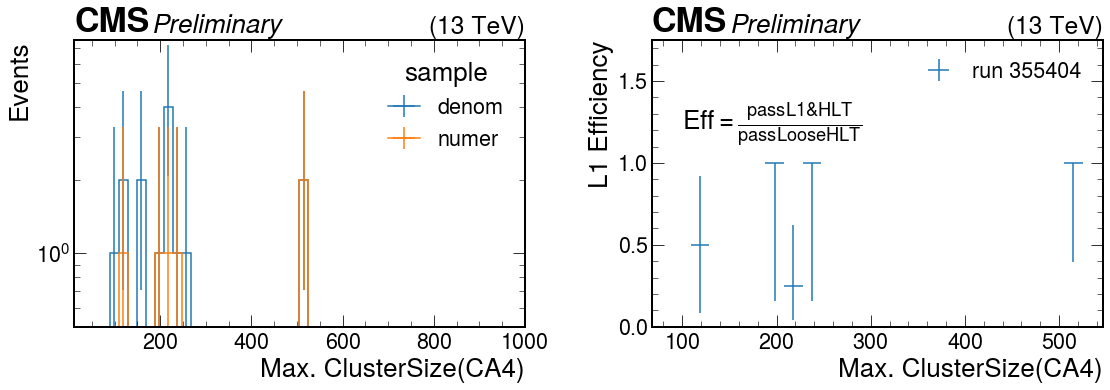

In [74]:
# sel = mu_veto&ak.all(cls.Nstation10>1,axis=1)

sel = HLTLoose
denom = ak.max(cls[sel].Size,axis=1)
numer = denom[hmt[sel].passL1==1]

plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(1,2, figsize=(16,6))
axs = axs.flatten()
h= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("ClusterSize", "ClusterSize", 50, 10, 1000))        
h.fill(sample="numer",ClusterSize=numer)
h.fill(sample="denom",ClusterSize=denom)
axs[0]=hist.plot1d(h,ax=axs[0])
axs[0].set_yscale("log")
axs[0].set_ylim(0.5,None)
axs[0].set_xlabel("Max. ClusterSize(CA4)")
hep.cms.label(ax=axs[0],data=True,label="Preliminary")

# sel = ak.all(cls.Nstation10>1,axis=1) 
denom = ak.max(cls[sel].Size,axis=1)
numer = denom[hmt[sel].passL1==1]    
plotEff(numer,denom,axs[1])
# sel = ak.all((cls.Nstation10>1),axis=1)&(mu_veto)
# denom = ak.max(cls[sel].Size,axis=1)
# numer = denom[hmt[sel].passL1==1]    
# plotEff(numer,denom,axs[1])
    
axs[1].set_ylabel("L1 Efficiency")
axs[1].set_xlabel("Max. ClusterSize(CA4)")
axs[1].legend(["run 355404"])
# axs[1].legend(["Nstation10>1","(Nstation10>1)&muveto"],title="run 355933")
axs[1].set_ylim(0,1.75)
axs[1].text(100,1.2,r'$Eff=\frac{passL1&HLT}{pass Loose HLT}$')
# axs[1].text(80,1.2,r'denom=(Nstation10==1)&&(TimeSpread<10)', fontsize=14)
# axs[1].text(80,1.2,r'denom=(Nstation10>1)&&(muonVeto)', fontsize=14)
# axs[1].text(80,1.1,r'numer=(denom&&passL1)',fontsize=14)
hep.cms.label(ax=axs[1],data=True,label="Preliminary")
plt.tight_layout()

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

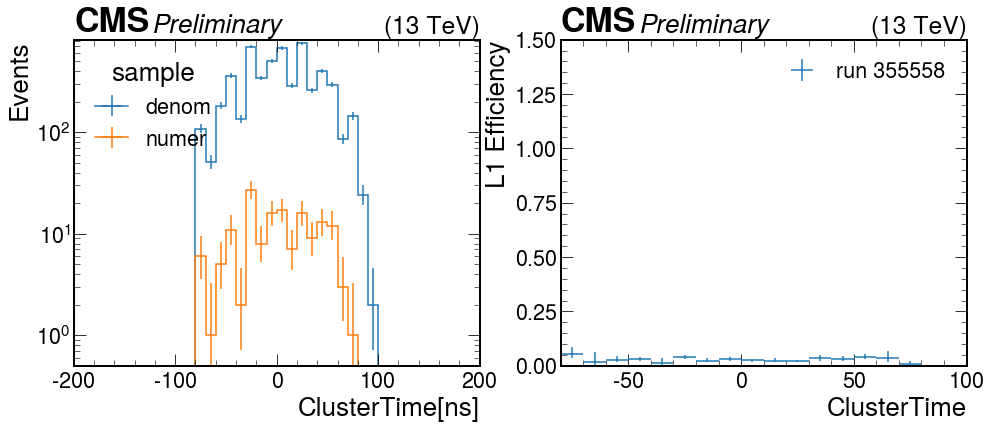

In [285]:
sel= ak.any((cls.Nstation10==1),axis=1)
maxCls = ak.flatten(cls[cls.Size==ak.max(cls.Size,axis=1)]) ## max size clusters 

denom = maxCls[sel]
numer = denom[hmt[sel].passL1==1]
# denom = maxCls.

plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(1,2, figsize=(16,6))
axs = axs.flatten()
h= hist.Hist("Events",hist.Cat("sample","sample"),
             hist.Bin("Time", "ClusterTime[ns]", 40, -200, 200))        
h.fill(sample="numer",Time=numer.Time)
h.fill(sample="denom",Time=denom.Time)
axs[0]=hist.plot1d(h,ax=axs[0])
axs[0].set_yscale("log")
axs[0].set_ylim(0.5,None)
# axs[0].set_xlabel("Max. ClusterSize(CA4)")
hep.cms.label(ax=axs[0],data=True,label="Preliminary")

hist.plotratio(num=h.integrate("sample",'numer'),
               denom=h.integrate("sample",'denom'),
                xerr=True,
               error_opts={"linestyle":'none',},
               ax=axs[1]
              )
axs[1].set_ylabel("L1 Efficiency")
axs[1].set_xlabel("ClusterTime")
axs[1].legend(["run 355558"])
axs[1].set_ylim(0,1.5)
hep.cms.label(ax=axs[1],data=True,label="Preliminary")

# L1 efficiency v.s. station

In [5]:
hmt

<Array [{passL1: 0, hasCluster: 1, ... 1]}] type='2319078 * {"passL1": int32, "h...'>

In [14]:
two_loose        = np.ceil(np.array([140,20  ,8,28 ,9,26 ,8,31,13])*0.8)

In [13]:
np.ceil(two_loose)

array([112.,  16.,   7.,  23.,   8.,  21.,   7.,  25.,  11.])

In [11]:
np.round(two_loose)

array([112.,  16.,   6.,  22.,   7.,  21.,   6.,  25.,  10.])

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encounter

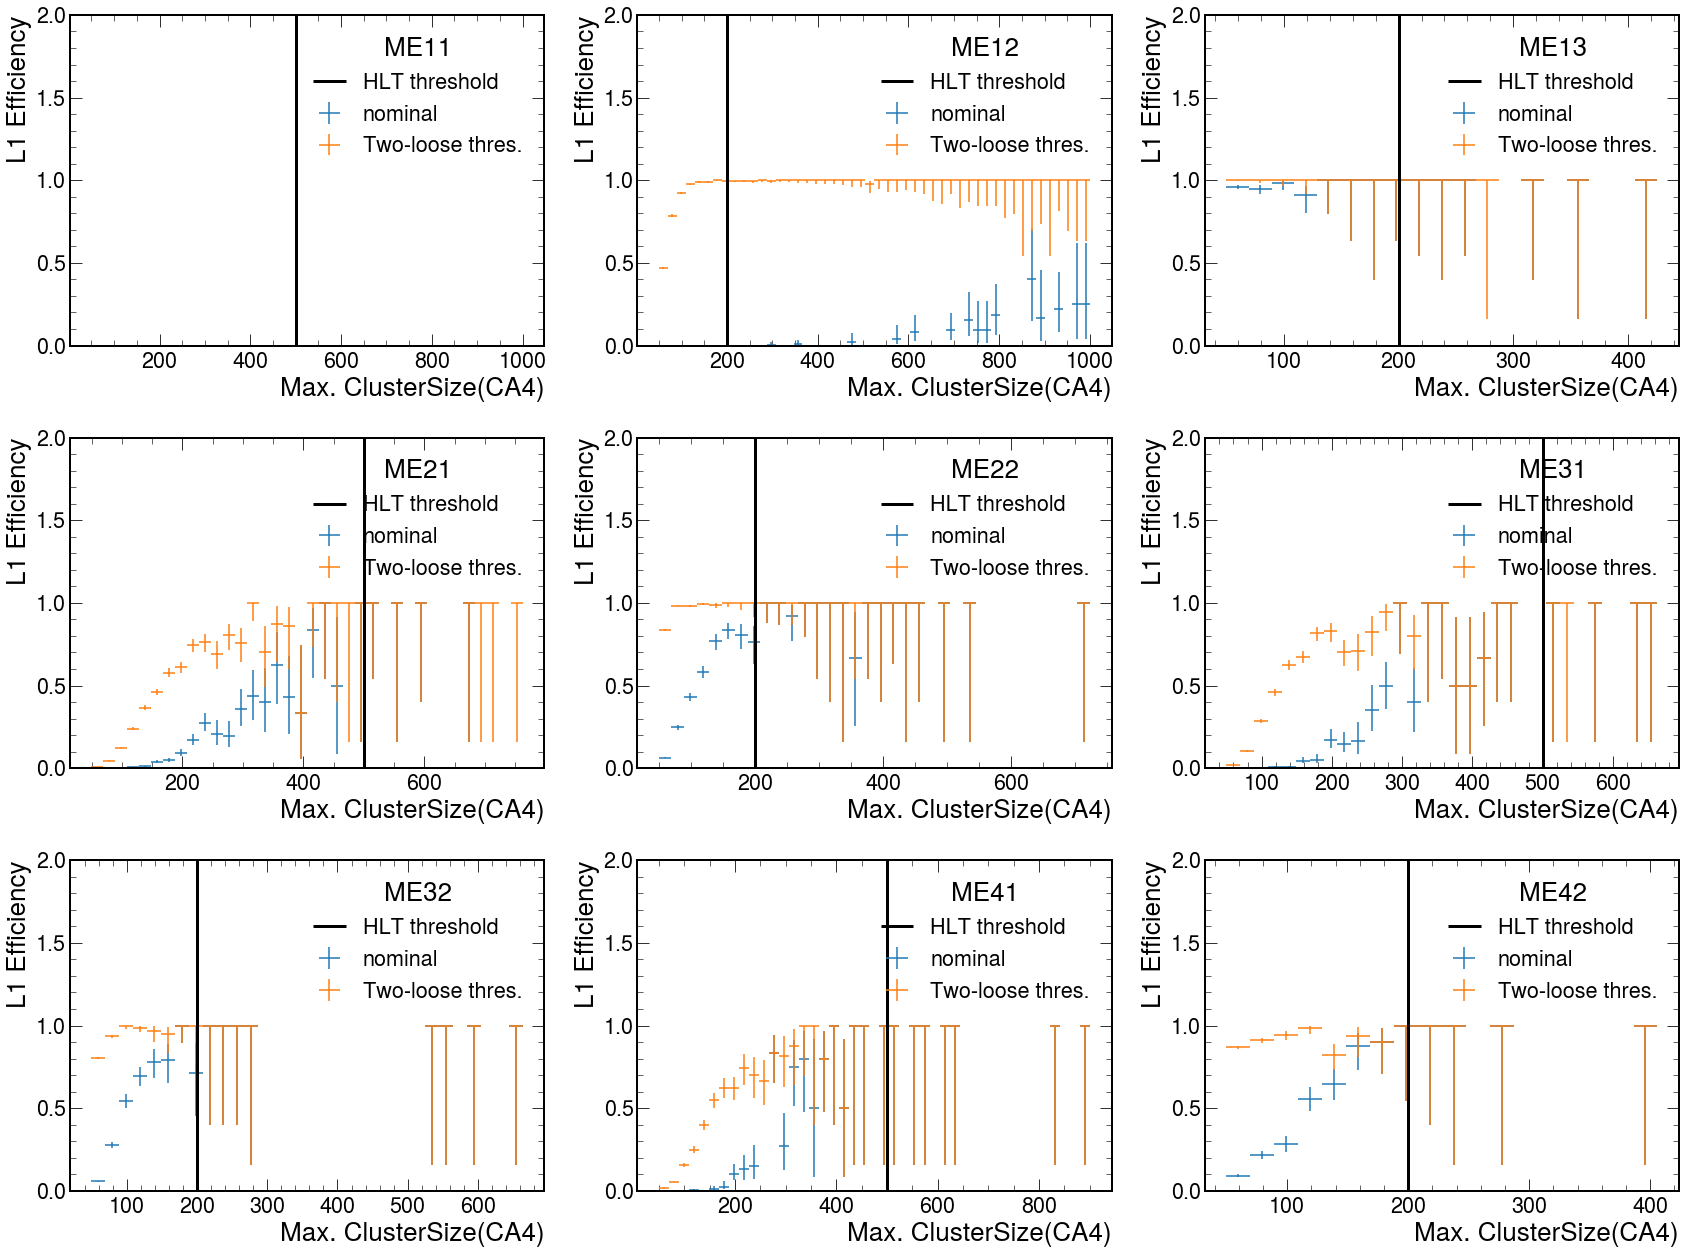

In [23]:
ME11 = (cls.R>100)&(cls.R<275) &(abs(cls.Z)>580)&(abs(cls.Z)<632) 
ME12 = (cls.R>275)&(cls.R<465) &(abs(cls.Z)>668)&(abs(cls.Z)<724)
ME13 = (cls.R>505)&(cls.R<700) &(abs(cls.Z)>668)&(abs(cls.Z)<724)

ME21 = (cls.R>139)&(cls.R<345) &(abs(cls.Z)>789)&(abs(cls.Z)<850)
ME22 = (cls.R>357)&(cls.R<700) &(abs(cls.Z)>791)&(abs(cls.Z)<850)

ME31 = (cls.R>160)&(cls.R<345) &(abs(cls.Z)>915)&(abs(cls.Z)<970)
ME32 = (cls.R>357)&(cls.R<700) &(abs(cls.Z)>911)&(abs(cls.Z)<970)

ME41 = (cls.R>178)&(cls.R<345) &(abs(cls.Z)>1002)&(abs(cls.Z)<1063)
ME42 = (cls.R>357)&(cls.R<700) &(abs(cls.Z)>1002)&(abs(cls.Z)<1063)

plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(3,3, figsize=(24,18))
axs = axs.flatten()

def plotEff(numer,denom,ax):
    h= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("ClusterSize", "ClusterSize", 50, 10, 1000))        
    h.fill(sample="numer",ClusterSize=numer)
    h.fill(sample="denom",ClusterSize=denom)

    hist.plotratio(num=h.integrate("sample",'numer'),
                   denom=h.integrate("sample",'denom'),
                    xerr=True,
                   error_opts={"linestyle":'none',},
                   ax=ax,clear=False
                  )
    return ax


for i,region in enumerate([ME11,ME12,ME13,ME21,ME22,ME31,ME32,ME41,ME42]):
    sel = ak.all(region&(cls.Nstation10==1),axis=1) 
    denom = ak.fill_none(ak.max(cls[sel].Size,axis=1),-1)
    numer = ak.fill_none(denom[hmt[sel].passL1==1],-1)    
#     plotEff(numer,denom,axs[i])
    
#thresholds       = [140,14,28,26]
#tight_thresholds = [140,18,32,34]

thresholds       = [140,140,14,56,28,55,26,62,27]
# two_loose        = [140,20  ,8,28 ,9,26 ,8,31,13]
two_loose        = np.ceil(np.array([140,20  ,8,28 ,9,26 ,8,31,13])*0.8)

#for i,ax_i in enumerate([1,2,4,6]):
for i,region in enumerate([ME11,ME12,ME13,ME21,ME22,ME31,ME32,ME41,ME42]):
    sel = ak.all(region&(cls.Nstation10==1),axis=1) 
    denom = ak.fill_none(ak.max(cls[sel].Size,axis=1),-1)
    numer = ak.fill_none(denom[ak.any(elctHMT[sel].WireNHits>thresholds[i],axis=1)],-1)    
    numer_twoLoose = ak.fill_none(denom[ak.any(elctHMT[sel].WireNHits>two_loose[i],axis=1)],-1)            
#     numer_tight = ak.fill_none(denom[ak.any(elctHMT[sel].WireNHits>tight_thresholds[i],axis=1)],-1)        
#     plotEff(numer,denom,axs[ax_i])
#     plotEff(numer_tight,denom,axs[ax_i])    
    plotEff(numer,denom,axs[i])
    plotEff(numer_twoLoose,denom,axs[i])    

    
labels = ["ME11","ME12","ME13",'ME21','ME22','ME31','ME32',"ME41","ME42"]
# runNumber = "run-355404"
runNumber = "run 357696-357756"
for i,ax in enumerate(axs):
    ax.set_ylabel("L1 Efficiency")
    ax.set_xlabel("Max. ClusterSize(CA4)")
    if i in [1,2,4,6,8]:
        ax.vlines(200,0,2,color='black',label="HLT threshold",lw=3)    
    else:
        ax.vlines(500,0,2,color='black',label="HLT threshold",lw=3)
#     if i in [1,2,4,6]:
#         ax.legend(["%s"%labels[i],"nominal","Two-loose"],title=runNumber)    
#     else:
#         ax.legend(["%s"%labels[i]],title=runNumber)            
    ax.legend(["HLT threshold",'nominal','Two-loose thres.'],title="%s"%labels[i])
    ax.set_ylim(0,2)
    plt.tight_layout()

# ME21

In [28]:
np.ceil(np.array([140,20  ,8,28 ,9,26 ,8,31,13])*0.8)

array([112.,  16.,   7.,  23.,   8.,  21.,   7.,  25.,  11.])

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


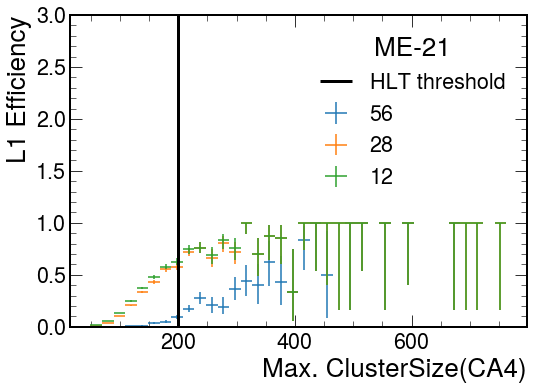

In [44]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

thresholds = [56,28,12]
region=ME21
sel = ak.all(region&(cls.Nstation10==1),axis=1) 
denom = ak.fill_none(ak.max(cls[sel].Size,axis=1),-1)
for threshold in thresholds:
    numer = ak.fill_none(denom[ak.any(elctHMT[sel].WireNHits>threshold,axis=1)],-1)
    plotEff(numer,denom,ax)  
        
ax.set_ylabel("L1 Efficiency")
ax.set_xlabel("Max. ClusterSize(CA4)")
ax.vlines(200,0,3,color='black',label="HLT threshold",lw=3)    

ax.legend(["HLT threshold"]+thresholds,title="ME-21")
ax.set_ylim(0,3)
plt.tight_layout()

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


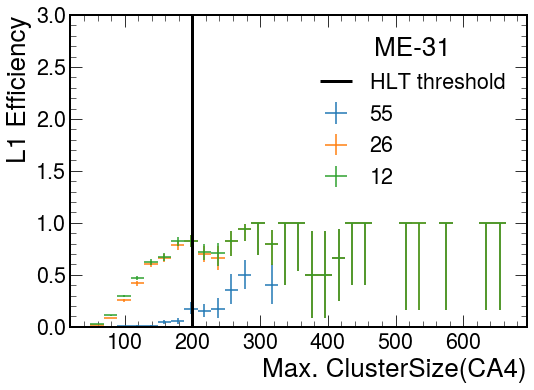

In [45]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

thresholds = [55,26,12]
region=ME31
sel = ak.all(region&(cls.Nstation10==1),axis=1) 
denom = ak.fill_none(ak.max(cls[sel].Size,axis=1),-1)
for threshold in thresholds:
    numer = ak.fill_none(denom[ak.any(elctHMT[sel].WireNHits>threshold,axis=1)],-1)
    plotEff(numer,denom,ax)  
        
ax.set_ylabel("L1 Efficiency")
ax.set_xlabel("Max. ClusterSize(CA4)")
ax.vlines(200,0,3,color='black',label="HLT threshold",lw=3)    

ax.legend(["HLT threshold"]+thresholds,title="ME-31")
ax.set_ylim(0,3)
plt.tight_layout()

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


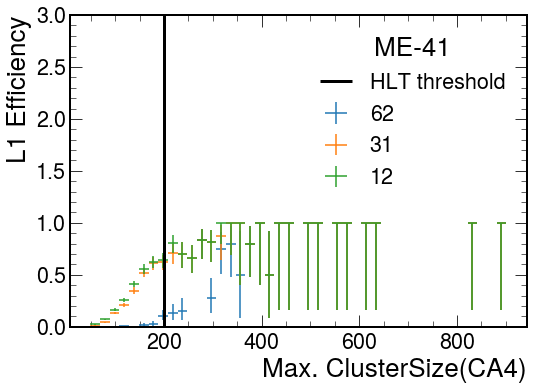

In [46]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

thresholds = [62,31,12]
region=ME41
sel = ak.all(region&(cls.Nstation10==1),axis=1) 
denom = ak.fill_none(ak.max(cls[sel].Size,axis=1),-1)
for threshold in thresholds:
    numer = ak.fill_none(denom[ak.any(elctHMT[sel].WireNHits>threshold,axis=1)],-1)
    plotEff(numer,denom,ax)  
        
ax.set_ylabel("L1 Efficiency")
ax.set_xlabel("Max. ClusterSize(CA4)")
ax.vlines(200,0,3,color='black',label="HLT threshold",lw=3)    

ax.legend(["HLT threshold"]+thresholds,title="ME-41")
ax.set_ylim(0,3)
plt.tight_layout()

In [74]:
region = ME12
sel = ak.all(region&(cls.Nstation10==1),axis=1) 
denom = ak.fill_none(ak.max(cls[sel].Size,axis=1),-1)
numer = ak.fill_none(denom[hmt[sel].passL1==1],-1)    

In [75]:
denom

<Array [78, 536, 91, 101, ... 55, 70, 132, 50] type='1081 * int64'>

In [76]:
denom[]

<Array [536, 148, 425, 487, ... 309, 171, 778] type='121 * int64'>

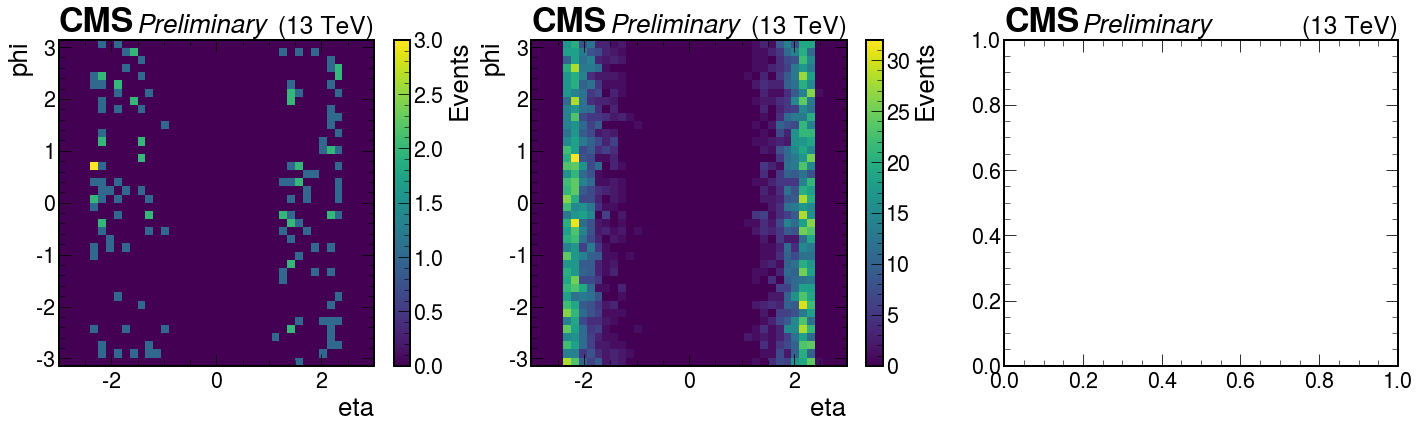

In [32]:
maxCls = ak.flatten(cls[cls.Size==ak.max(cls.Size,axis=1)]) ## max size clusters 

denom = maxCls[sel]
numer = denom[hmt[sel].passL1==1]
# denom = maxCls.

plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(1,3, figsize=(24,6))
axs = axs.flatten()
h= hist.Hist("Events",hist.Cat("sample","sample"),
             hist.Bin("eta", "eta", 40, -3, 3),
             hist.Bin("phi", "phi", 40, -np.pi, np.pi))        
h.fill(sample="numer",eta=numer.Eta,phi=numer.Phi)
h.fill(sample="denom",eta=denom.Eta,phi=denom.Phi)
hist.plot2d(h["numer"].sum("sample"),xaxis="eta",ax=axs[0])
hist.plot2d(h["denom"].sum("sample"),xaxis="eta",ax=axs[1])

for ax in axs:
    hep.cms.label(ax=ax,data=True,label="Preliminary")

In [46]:
ME12 = (cls.R>275)&(cls.R<465) &(abs(cls.Z)>668)&(abs(cls.Z)<724)
ME12_sr = (hmt.elctHMT_sr==7)|(hmt.elctHMT_sr==10)
sel = ak.any(ME12,axis=1)&ak.any(ME12_sr,axis=1)


<PtEtaPhiMLorentzVectorArray [[], [], [], ... AvgStation10: 1}], []] type='7556 ...'>

In [ ]:
arr_str = ["4/2", "4/1", "3/2", "3/1", "2/2", "2/1", "1/3", "1/2", "1/1"]


In [107]:
ak.max(cls[sel].Size,axis=1)

<Array [191, 308, 297, 53, ... 81, 120, 136] type='139 * ?float32'>

In [106]:
ak.max(hmt.elctHMT_WireNHits[sel],axis=1)

<Array [53, 20, 34, 27, 39, ... 24, 22, 34, 29] type='139 * ?int32'>

In [102]:
ak.flatten(hmt.elctHMT_sr[sel])

<Array [7, 10, 10, 7, 10, ... 10, 7, 10, 10] type='155 * int32'>

In [104]:
ak.flatten(cls[sel].Size)

<Array [191, 308, 297, 53, ... 81, 120, 136] type='143 * float32'>

In [68]:
ak.flatten(hmt.elctHMT_WireNHits[sel])

<Array [53, 20, 34, 27, 39, ... 24, 22, 34, 29] type='145 * int32'>

Text(0.8, 0.9, 'ME12')

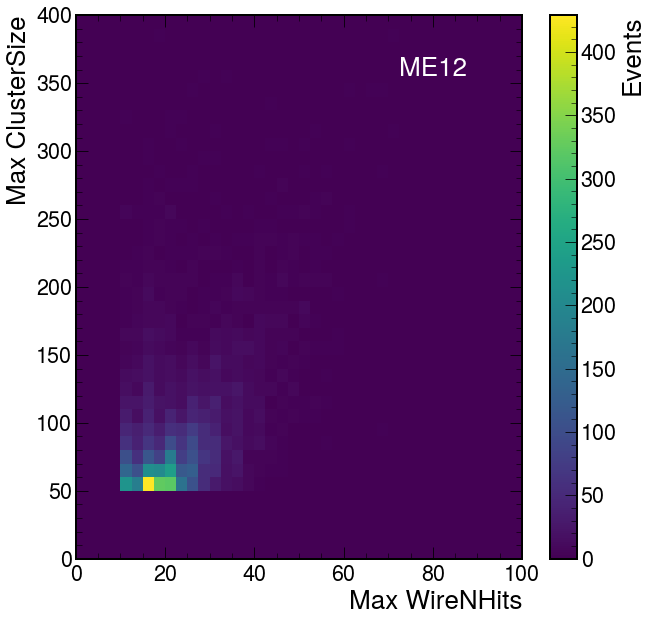

In [7]:
def plotCorr(ax,c,w):
    h= hist.Hist("Events",
                 hist.Bin("ClusterSize", "Max ClusterSize", 40, 0, 400),
                 hist.Bin("WireNHits", "Max WireNHits", 40, 0, 100))
    h.fill(ClusterSize =ak.max(c,axis=1),
           WireNHits   =ak.max(w,axis=1))
    hist.plot2d(h,xaxis="WireNHits",ax=ax)
    return ax


ME12 = (cls.R>275)&(cls.R<465) &(abs(cls.Z)>668)&(abs(cls.Z)<724)
ME12_sr = (hmt.elctHMT_sr==7)|(hmt.elctHMT_sr==10)
sel = ak.any(ME12,axis=1)&ak.any(ME12_sr,axis=1)

fig,ax = plt.subplots()
ax=plotCorr(ax,cls[sel].Size,hmt[sel].elctHMT_WireNHits)
ax.text(0.8,0.9,"ME12",color='white',
        horizontalalignment='center',verticalalignment='center',
        transform=ax.transAxes)

In [45]:
ak.sum(ak.num(hmt.elctHMT_sr[ME11_sr]))

184

In [27]:
np.unique(ak.flatten(hmt.elctHMT_sr))

<Array [0, 1, 2, 3, 4, ... 13, 14, 15, 16, 17] type='16 * int32'>

In [23]:
hmt.elctHMT_sr

<Array [[5], [], [], [], ... [], [], [10], []] type='7556 * var * int32'>

In [114]:
np.unique(ak.flatten(hmt.elctHMT_sr))
# ak.flatten(hmt.elctHMT_WireNHits)

<Array [0, 1, 2, 3, 4, ... 13, 14, 15, 16, 17] type='16 * int32'>

In [10]:
def plotCorr(ax,c,w):
    h= hist.Hist("Events",
                 hist.Bin("ClusterSize", "Max ClusterSize", 40, 0, 200),
                 hist.Bin("WireNHits", "Max WireNHits", 40, 0, 80))
    h.fill(ClusterSize =ak.max(c,axis=1),
           WireNHits   =ak.max(w,axis=1))
    hist.plot2d(h,xaxis="WireNHits",ax=ax)
    return ax

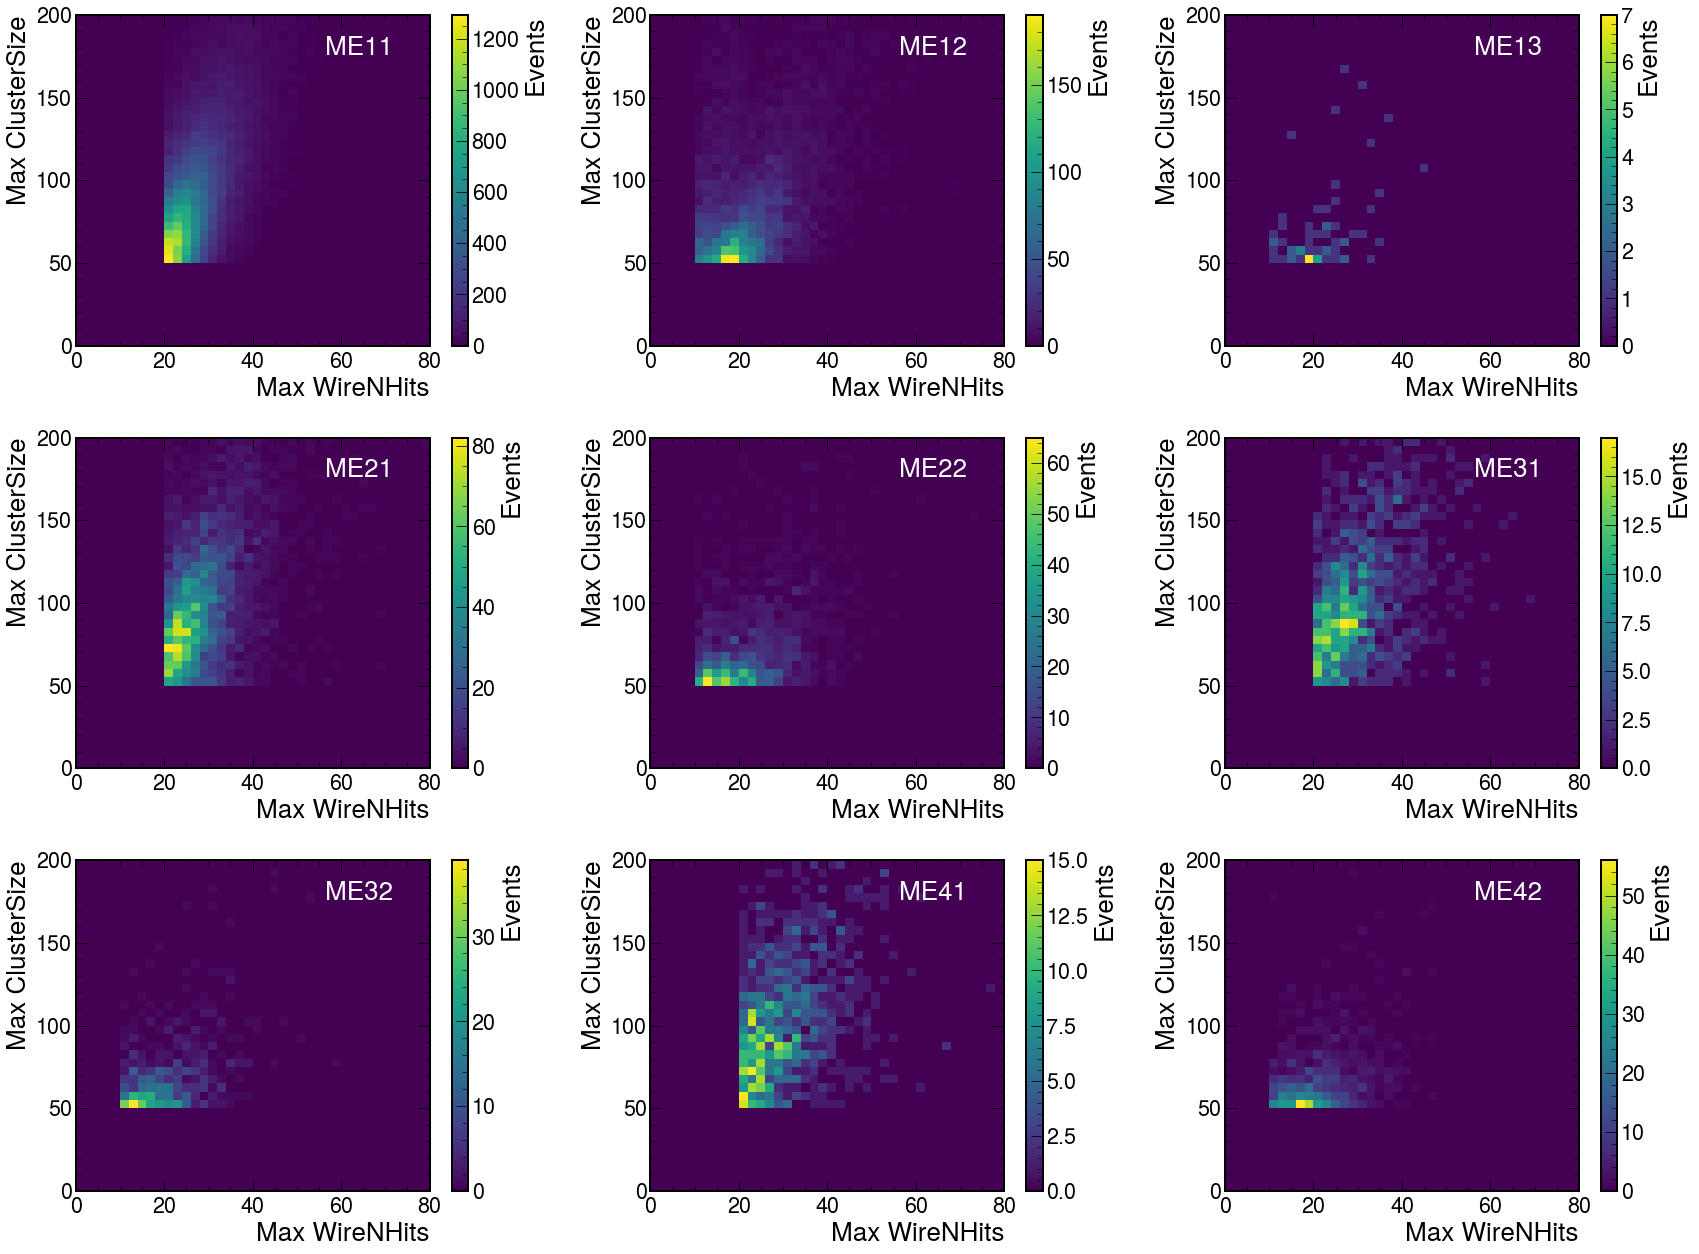

In [11]:
ME11 = (cls.R>100)&(cls.R<275) &(abs(cls.Z)>580)&(abs(cls.Z)<632) 
ME12 = (cls.R>275)&(cls.R<465) &(abs(cls.Z)>668)&(abs(cls.Z)<724)
ME13 = (cls.R>505)&(cls.R<700) &(abs(cls.Z)>668)&(abs(cls.Z)<724)

ME21 = (cls.R>139)&(cls.R<345) &(abs(cls.Z)>789)&(abs(cls.Z)<850)
ME22 = (cls.R>357)&(cls.R<700) &(abs(cls.Z)>791)&(abs(cls.Z)<850)

ME31 = (cls.R>160)&(cls.R<345) &(abs(cls.Z)>915)&(abs(cls.Z)<970)
ME32 = (cls.R>357)&(cls.R<700) &(abs(cls.Z)>911)&(abs(cls.Z)<970)

ME41 = (cls.R>178)&(cls.R<345) &(abs(cls.Z)>1002)&(abs(cls.Z)<1063)
ME42 = (cls.R>357)&(cls.R<700) &(abs(cls.Z)>1002)&(abs(cls.Z)<1063)

ME11_sr = (hmt.elctHMT_sr==8)|(hmt.elctHMT_sr==9)
ME12_sr = (hmt.elctHMT_sr==7)|(hmt.elctHMT_sr==10)
ME13_sr = (hmt.elctHMT_sr==6)|(hmt.elctHMT_sr==11)

ME21_sr = (hmt.elctHMT_sr==5)|(hmt.elctHMT_sr==12)
ME22_sr = (hmt.elctHMT_sr==4)|(hmt.elctHMT_sr==13)

ME31_sr = (hmt.elctHMT_sr==3)|(hmt.elctHMT_sr==14)
ME32_sr = (hmt.elctHMT_sr==2)|(hmt.elctHMT_sr==15)

ME41_sr = (hmt.elctHMT_sr==1)|(hmt.elctHMT_sr==16)
ME42_sr = (hmt.elctHMT_sr==0)|(hmt.elctHMT_sr==17)

plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(3,3, figsize=(24,18))
axs = axs.flatten()

for i,region in enumerate(zip(
    [ME11,ME12,ME13,ME21,ME22,ME31,ME32,ME41,ME42],
    [ME11_sr,ME12_sr,ME13_sr,ME21_sr,ME22_sr,ME31_sr,ME32_sr,ME41_sr,ME42_sr])):
    
    sel = ak.any(region[0],axis=1)&ak.any(region[1],axis=1) 
    if ak.sum(sel)>0:
        plotCorr(axs[i],cls[sel].Size,hmt[sel].elctHMT_WireNHits)
    

labels = ["ME11","ME12","ME13",'ME21','ME22','ME31','ME32',"ME41","ME42"]
runNumber = "run-355933"
for i,ax in enumerate(axs):
    ax.text(0.8,0.9,labels[i],color='white',
        horizontalalignment='center',verticalalignment='center',
        transform=ax.transAxes)
plt.tight_layout()

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary'))

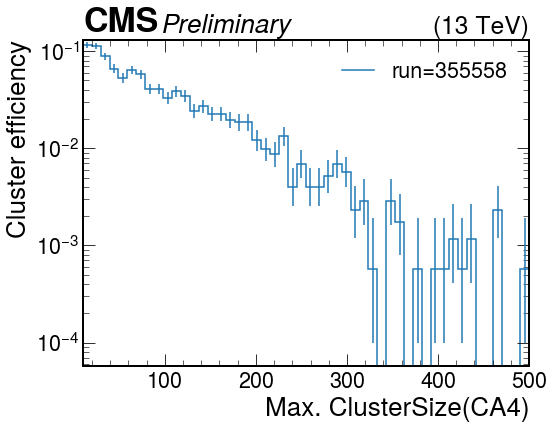

In [28]:

total = ak.sum(hmt.passL1)
numer = ak.max(cls[hmt.passL1==1].Size,axis=1)
# denom = maxCls.

plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(1,1, figsize=(8,6))
h= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("ClusterSize", "ClusterSize", 50, 10, 500))        
h.fill(sample="numer",ClusterSize=numer)
h.scale(1/total)
axs=hist.plot1d(h,ax=axs)
axs.set_yscale("log")
axs.set_ylim(0.1/total,None)
axs.set_xlabel("Max. ClusterSize(CA4)")
axs.set_ylabel("Cluster efficiency")
axs.legend(["run=355558"])
hep.cms.label(ax=axs,data=True,label="Preliminary")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

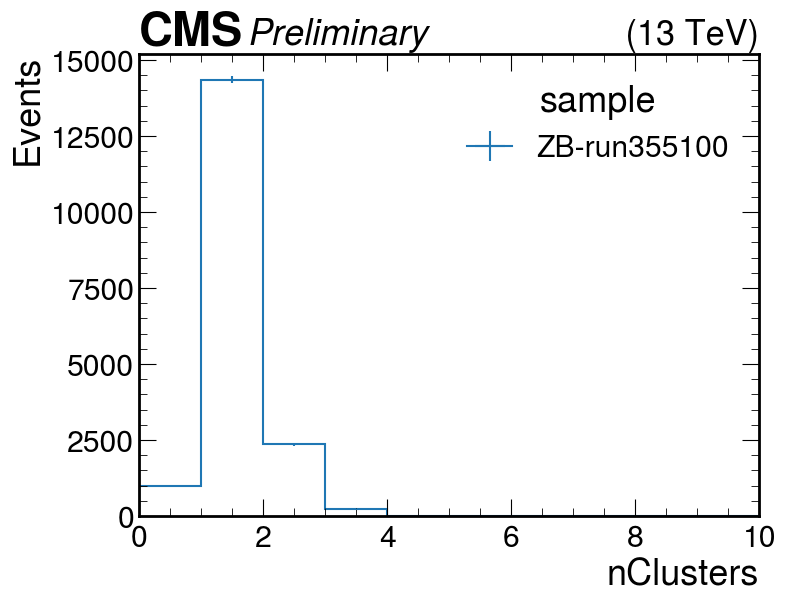

In [29]:
plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(1,1, figsize=(8,6))
h4= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nClusters", "nClusters", 10, 0, 10))        
h4.fill(sample="ZB-run355100",nClusters=ak.num(events.cls))
ax=hist.plot1d(h4)
# ax.set_yscale("log")
# ax.set_ylim(0.5,None)

hep.cms.label(ax=ax,data=True,label="Preliminary")

In [ ]:
plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(1,1, figsize=(8,6))
h4= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("size", "size", 100, 0, 1000))        
h4.fill(sample="ZB-run355100",size=ak.flatten(events.cls.size))
ax=hist.plot1d(h4)
ax.set_yscale("log")
ax.set_ylim(0.5,None)

hep.cms.label(ax=ax,data=True,label="Preliminary")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

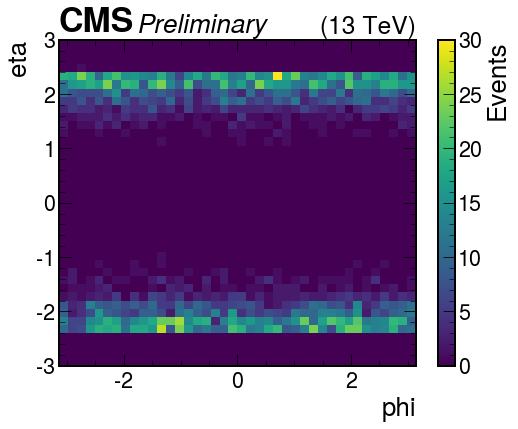

In [43]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
h= hist.Hist("Events",
              hist.Bin("eta", "eta", 40, -3, 3),
              hist.Bin("phi", "phi", 40, -np.pi, np.pi)  )
h.fill(eta=ak.flatten(events.cls.eta),phi=ak.flatten(events.cls.phi))
hist.plot2d(h,xaxis="phi",ax=ax)
hep.cms.label(ax=ax,data=True,label="Preliminary")

In [40]:
import matplotlib.patches as patches

def to_str(sr):
    arr_str = ["4/2", "4/1", "3/2", "3/1", "2/2", "2/1", "1/3", "1/2", "1/1"]
    ans = []
    for i in sr:
        if i<=8: ans.append("ME-"+arr_str[i])
        else: ans.append("ME+"+arr_str[17-i])
    return ans

def drawRZ(ax,MB_xmin=300):
    ax.set_ylim(0,750)
    ax.set_xlim(0,1100)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]
    
    MB1 = patches.Rectangle((MB_xmin,402),661-MB_xmin,449-402,color='grey',alpha=0.3)
    MB2 = patches.Rectangle((MB_xmin,490),661-MB_xmin,533-490,color='grey',alpha=0.3)
    MB3 = patches.Rectangle((MB_xmin,597),661-MB_xmin,636-597,color='grey',alpha=0.3)
    MB4 = patches.Rectangle((MB_xmin,700),661-MB_xmin,738-700,color='grey',alpha=0.3)

    solenoid= patches.Rectangle((MB_xmin,295),661-MB_xmin,380-295,color='grey',alpha=0.3)

    ME22 = patches.Rectangle((791,357),850-791,700-357,color='grey',alpha=0.3)
    ME32 = patches.Rectangle((911,357),970-911,700-357,color='grey',alpha=0.3)
    ME42 = patches.Rectangle((1002,357),1063-1002,700-357,color='grey',alpha=0.3)

    ME21 = patches.Rectangle((789,139),850-789,345-139,color='grey',alpha=0.3)
    ME31 = patches.Rectangle((915,160),970-915,345-160,color='grey',alpha=0.3)
    ME41 = patches.Rectangle((1002,178),1063-1002,345-178,color='grey',alpha=0.3)

    ME11 = patches.Rectangle((580,100),632-580,275-100,color='grey',alpha=0.3)
    ME12 = patches.Rectangle((668,275),724-668,465-275,color='grey',alpha=0.3)
    ME13 = patches.Rectangle((686,505),724-686,700-505,color='grey',alpha=0.3)
    
    list_of_boxes = [ME11,ME12,ME13,ME21,ME22,ME31,ME32,ME41,ME42,MB1,MB2,MB3,MB4,solenoid]
    
    for box in list_of_boxes:
        ax.add_patch(box)
    
    ax.text(410, 415, "MB1",fontsize=12)
    ax.text(410, 500, "MB2",fontsize=12)
    ax.text(410, 605, "MB3",fontsize=12)
    ax.text(410, 708, "MB4",fontsize=12)
    
    ax.text(665, 705, "ME1/3",fontsize=12)
    ax.text(780, 705, "ME2/2",fontsize=12)
    ax.text(900, 705, "ME3/2",fontsize=12)
    ax.text(990, 705, "ME4/2",fontsize=12)


    #ax.text(680, 140, "Steel",fontsize=12)
    #ax.text(410,660, "Steel",fontsize=12)
    ax.text(410, 330, "Solenoid",fontsize=12)
    #ax.text(430, 150, "HCAL",fontsize=12)

    ax.text(615, 110, "ME1/1",rotation='vertical',fontsize=12)
    ax.text(695, 331, "ME1/2",rotation='vertical',fontsize=12)
    ax.text(830, 145, "ME2/1",rotation='vertical',fontsize=12)
    ax.text(955, 170, "ME3/1",rotation='vertical',fontsize=12)
    ax.text(1040, 190, "ME4/1",rotation='vertical',fontsize=12)
    return ax


def display(i_event,cls,save=False):
#     i_event = 3
    plt.style.use(hep.style.CMS) 
    i_cls = cls[i_event]
    fig, axs = plt.subplots(1,1, figsize=(8,6))

    axs.scatter(i_cls.Eta,i_cls.Phi,s=i_cls.Size,label="Cluster")
    for cl in i_cls:
        cone = plt.Circle((cl.Eta, cl.Phi), 0.4, color='b', fill=False,)
        axs.add_patch(cone)
    axs.set_ylim(-5,5)
    axs.set_xlim(-5,5)
    axs.set_ylabel(r"$\phi$")
    axs.set_xlabel(r"$\eta$")
    leg = axs.legend(bbox_to_anchor=(0.95, 1.0), loc='upper left')
    hep.cms.label(ax=axs,data=True,label="Preliminary")    
    for l in leg.legendHandles:
        l._sizes = [30]
    print("Cluster eta  = ",cls[i_event].Eta)
    print("Cluster phi  = ",cls[i_event].Phi)
    print("Cluster Size  = ",cls[i_event].Size)
    print("Cluster time  = ",cls[i_event].Time)
    if save:
        fig.savefig("eventDisplay_%s.pdf"%i_event)
        
def displayRZ(i_event,cls,hmt,save=False):
#     i_event = 3
    plt.style.use(hep.style.CMS) 
    i_cls = cls[i_event]
    i_rh_full = hmt[i_event]
    i_rh = i_rh_full
    fig, axs = plt.subplots(1,2, figsize=(18,8))

    axs = axs.flatten()
    s1=axs[0].scatter(i_cls.Eta,i_cls.Phi,s=i_cls.Size,label="Cluster")
    s2=axs[0].scatter(i_rh.cscRechitsEta,i_rh.cscRechitsPhi,s=1,label="Rechits")    
    if i_rh.nMuons>0:
        s3= axs[0].scatter(i_rh.muonEta,i_rh.muonPhi,s=i_rh.muonPt*10,label="Muon")        

    cls_r = (i_cls.X**2+i_cls.Y**2)**0.5
    rh_r = (i_rh.cscRechitsX**2+i_rh.cscRechitsY**2)**0.5    

    axs[1].scatter(np.abs(i_cls.Z),cls_r,s=i_cls.Size)    
    axs[1].scatter(np.abs(i_rh.cscRechitsZ),rh_r,s=1)     

    drawMuon=False
    if ((drawMuon) & (i_rh.nMuons>0)):    
        theta=2*np.arctan(np.exp(-i_rh.muonEta))
        slopes =np.sin(theta)
        for i,s in enumerate(slopes):
            s4=axs[1].plot([0,1100],[0,s*1100],label="Muon(pt,eta)=(%.1f,%.1f)"%(i_rh.muonPt[i],i_rh.muonEta[i]))

    MB_xmin = 300
    drawRZ(axs[1],MB_xmin)
    axs[1].set_xlim(MB_xmin,None)
    axs[1].set_xlabel("|z|[cm]")
    axs[1].set_ylabel("R[cm]")
    for cl in i_cls:
        cone = plt.Circle((cl.Eta, cl.Phi), 0.4, color='b', fill=False,)
        axs[0].add_patch(cone)
    axs[0].set_ylim(-np.pi,np.pi)
    axs[0].set_xlim(-5,5)
    axs[0].set_ylabel(r"$\phi$")
    axs[0].set_xlabel(r"$\eta$")
#     leg = axs[1].legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')    

    handles, labels = [(a + b) for a, b in zip(axs[0].get_legend_handles_labels(), 
                                           axs[1].get_legend_handles_labels())]
    leg=fig.legend(handles, labels,
                   bbox_to_anchor=(1.0, 1.0), loc='upper left')   
    for ax in axs:
        hep.cms.label(ax=ax,data=True,label="Preliminary")    
    for l in leg.legendHandles:
        l._sizes = [30]
    plt.tight_layout()
    print("Cluster eta  = ",cls[i_event].Eta)
    print("Cluster phi  = ",cls[i_event].Phi)
    print("Cluster Size  = ",cls[i_event].Size)
    print("Cluster time  = ",cls[i_event].Time)
    print("Cluster timeSpread  = ",cls[i_event].TimeSpread)    
    print("nRechits  = ",i_rh.ncscRechits)
    print("Rechits unique station/ring  = ",np.unique(i_rh.cscRechitsChamber))    
    print("Rechits unique chambers  = ",np.unique(i_rh.cscRechitsIChamber))        
    print("passL1  = ",i_rh.passL1)        
    print("(nlctHMT,nelctHMT)  = (%i,%i)"%(i_rh.nlctHMT,i_rh.nelctHMT))
    if i_rh.nlctHMT>0:
        print("lctHMT bits = ",i_rh.lctHMT_bits)
        print("lctHMT sr = ",to_str(i_rh.lctHMT_sr))    
        print("lctHMT BX = ",i_rh.lctHMT_BX)                              
        print("lctHMT (ComparatorNHits,wireNhits) = (%s,%s)"%(i_rh.lctHMT_ComparatorNHits,i_rh.lctHMT_WireNHits))
        print("lctHMT wireNhits = ",i_rh.lctHMT_WireNHits)  
    if i_rh.nelctHMT>0:
        print("elctHMT bits = ",i_rh.elctHMT_bits)
        print("elctHMT sr = ",to_str(i_rh.elctHMT_sr))              
        print("elctHMT BX = ",i_rh.elctHMT_BX)                      
        print("ectHMT (ComparatorNHits,wireNhits) = (%s,%s)"%(i_rh.elctHMT_ComparatorNHits,i_rh.elctHMT_WireNHits))
    if save:
        fig.savefig("eventDisplay_%s.pdf"%i_event)

In [208]:
hmt.cscRechitsIChamber

<Array [[17, 17, 17, 17, ... 10, 10, 10, 10]] type='7556 * var * int32'>

In [107]:
print(events.info[27])

{runNum: 355933, lumiNum: 377, evtNum: 171296051}


In [109]:
print(events.info[1634])

{runNum: 355933, lumiNum: 184, evtNum: 102781989}


In [247]:
print(events.info[50])

{runNum: 355933, lumiNum: 244, evtNum: 124153875}


In [202]:
np.where(ak.max(cls.Size,axis=1)==ak.max(cls.Size))

(<Array [658] type='1 * int64'>,)

In [158]:
np.where((hmt.nelctHMT>=1) & (hmt.passL1==1) &
         ak.any((cls.Size>=100)&(cls.Nstation10==1)&(cls.Time>50),axis=1))[0].tolist()

[2483, 4678]

In [137]:
x=np.where( (hmt.passL1==0) & (mu_veto) &
         ak.any(ME21&(cls.Nstation10==1)&(cls.Size>150),axis=1))
print(x)
events.info[x].to_list()

(<Array [442, 793, 3173, ... 4883, 4907, 7421] type='10 * int64'>,)


[{'runNum': 355933, 'lumiNum': 15, 'evtNum': 3852627},
 {'runNum': 355933, 'lumiNum': 267, 'evtNum': 132037735},
 {'runNum': 355933, 'lumiNum': 27, 'evtNum': 8501745},
 {'runNum': 355933, 'lumiNum': 28, 'evtNum': 9778741},
 {'runNum': 355933, 'lumiNum': 28, 'evtNum': 9873727},
 {'runNum': 355933, 'lumiNum': 57, 'evtNum': 45917261},
 {'runNum': 355933, 'lumiNum': 51, 'evtNum': 36099912},
 {'runNum': 355933, 'lumiNum': 219, 'evtNum': 115039877},
 {'runNum': 355933, 'lumiNum': 221, 'evtNum': 116061601},
 {'runNum': 355933, 'lumiNum': 283, 'evtNum': 137897115}]

In [37]:
np.where((ak.num(cls.Size)==1) & ak.any(cls.Size>500,axis=1))

(<Array [10115, 14342, ... 491366, 496364] type='88 * int64'>,)

In [36]:
 ak.any(cls.Size>500)

True

In [22]:
np.where(ak.any(cls.Size==ak.max(cls.Size),axis=1))

(<Array [320302] type='1 * int64'>,)

In [139]:
np.where(hmt.nMuons==1)

(<Array [1, 2, 3, 8, ... 7547, 7549, 7552, 7554] type='1648 * int64'>,)

In [229]:
muons[504].to_list()

[]

Cluster eta  =  [1.32]
Cluster phi  =  [-2.57]
Cluster Size  =  [767]
Cluster time  =  [-20.3]
Cluster timeSpread  =  [12]
nRechits  =  776
Rechits unique station/ring  =  [11, 12]
Rechits unique chambers  =  [22, 23, 35]
passL1  =  1
(nlctHMT,nelctHMT)  = (2,2)
lctHMT bits =  [2, 1]
lctHMT sr =  ['ME+1/2', 'ME+1/2']
lctHMT BX =  [5, 5]
lctHMT (ComparatorNHits,wireNhits) = ([0, 0],[0, 0])
lctHMT wireNhits =  [0, 0]
elctHMT bits =  [2, 1]
elctHMT sr =  ['ME+1/2', 'ME+1/2']
elctHMT BX =  [8, 8]
ectHMT (ComparatorNHits,wireNhits) = ([0, 0],[25, 13])


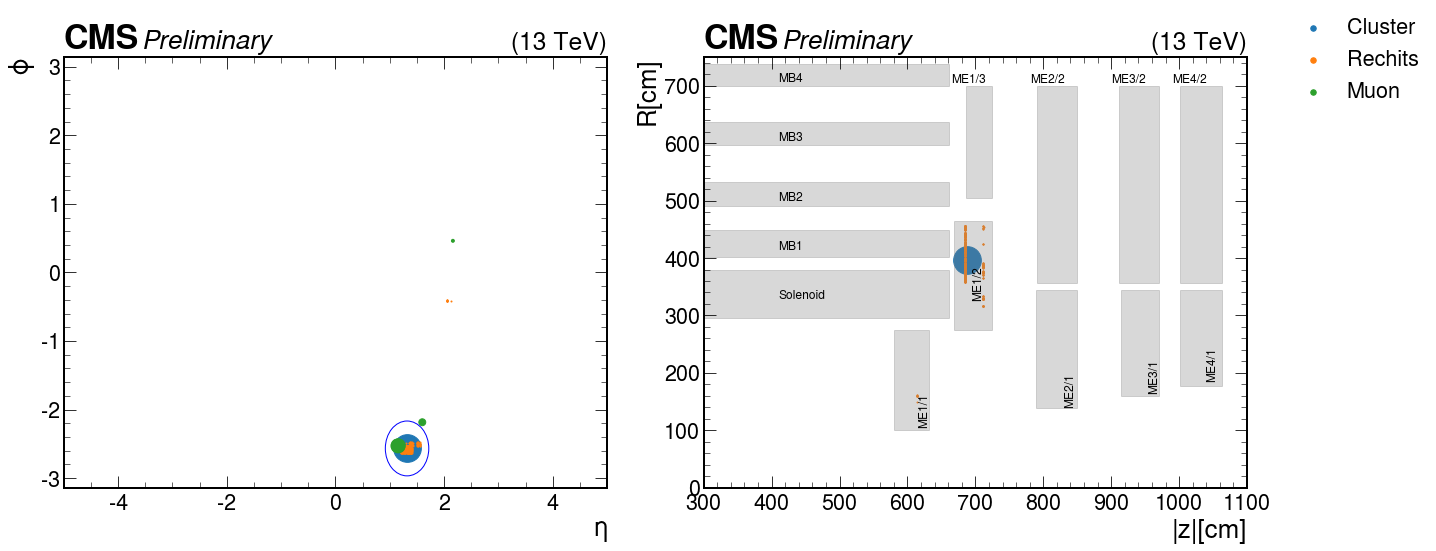

In [41]:
displayRZ(10115,cls,hmt)

Cluster eta  =  [-2.33, -1.93, -2.38, 2.19]
Cluster phi  =  [-0.738, 2.54, -3.05, 0.0402]
Cluster Size  =  [12, 12, 11, 130]
Cluster time  =  [-5.14, -2.23, 1.06, -4.66]


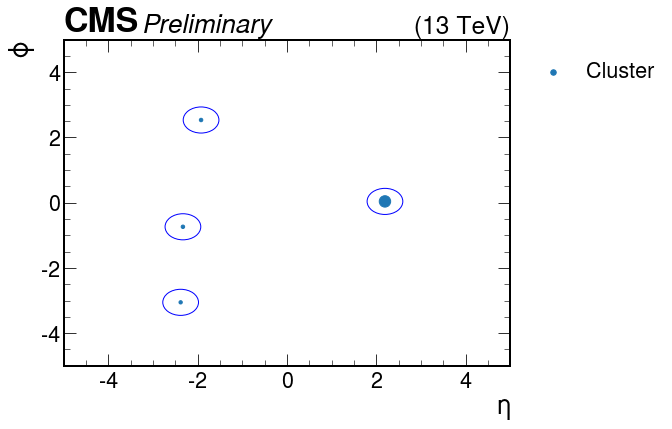

In [39]:
display(2706,cls)

Cluster eta  =  [-2.24, -2.06]
Cluster phi  =  [-0.505, 0.832]
Cluster Size  =  [172, 15]
Cluster time  =  [-1.44, 3.39]


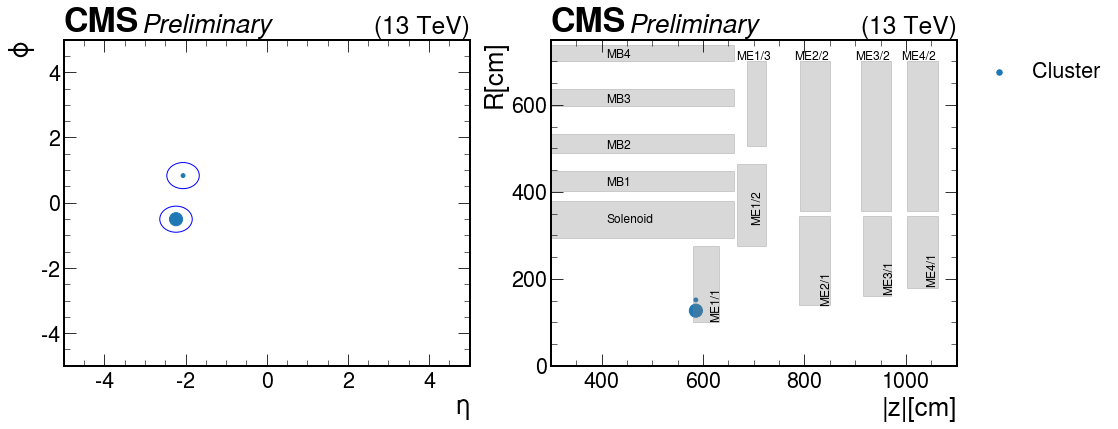

In [30]:
displayRZ(17928,cls)

Cluster eta  =  [1.52]
Cluster phi  =  [-1.94]
Cluster Size  =  [1.49e+03]
Cluster time  =  [2.29]


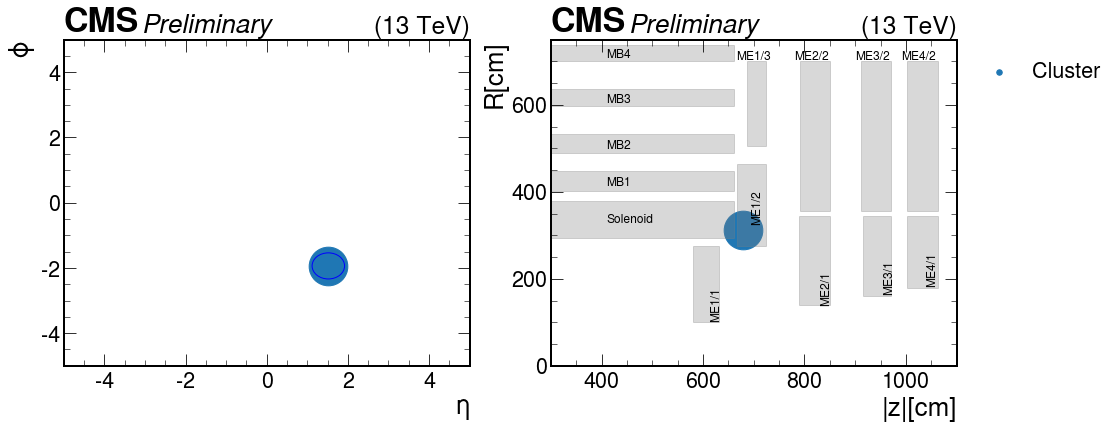

In [28]:
# display(13795,cls)
displayRZ(13795,cls)
